# Joining with Margins

By Sean McGuire

When joining catalogs, it is possible that the points on either side of the join are not in the same partition. To solve this issue, we use the margin of the right catalog, so that any joins whose points are close together in space such as joining objects to sources will be able to accurately join. This notebook will demonstrate how joining now works with a margin.

Another feature included here is querying a catalog with a margin and having the query carry over to the margin. This is useful for when you want to query a catalog and then join it to another catalog.

In [37]:
import lsdb
import numpy as np
import pandas as pd
from hipscat.inspection import plot_pixels
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import healpy as hp

### Reading in the Catalogs

In [2]:
sso1m = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_order1_source_margin")
sso1m

/astro/users/seanmcgu/hipscat_deploy/src/hipscat/catalog/partition_info.py:138: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")


,id,ra,dec,ra_error,dec_error,obj_id,margin_Norder,margin_Dir,margin_Npix,Norder,Npix,Dir
npartitions=5,,,,,,,,,,,,
4611686018427387904,int64,float64,float64,int64,int64,int64,int64,int64,int64,uint8,uint64,uint64
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
sso1_source = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_order1_source", margin_cache=sso1m)
sso1_source

,id,ra,dec,ra_error,dec_error,obj_id,Norder,Dir,Npix
npartitions=4,,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int64,int64,int64,int64
12970366926827028480,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...


In [4]:
sso1 = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_order1")
sso1

,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix
npartitions=4,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int32,int32,int32
12970366926827028480,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


### Plotting the Catalogs

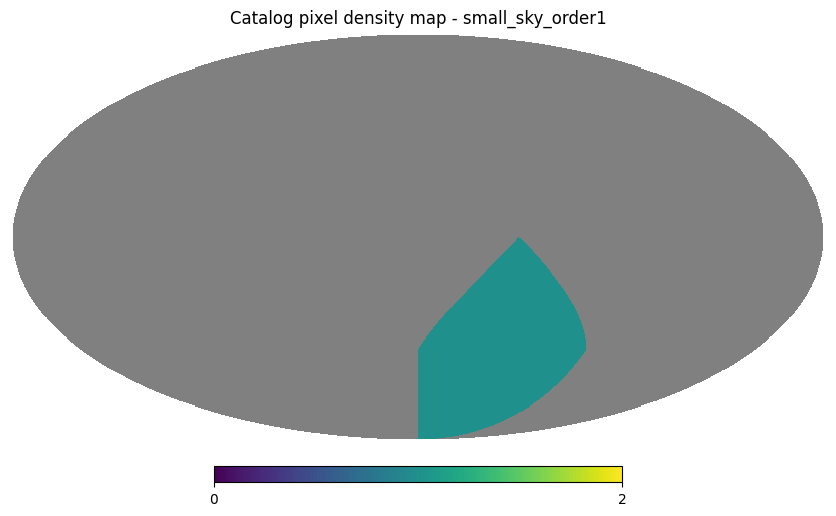

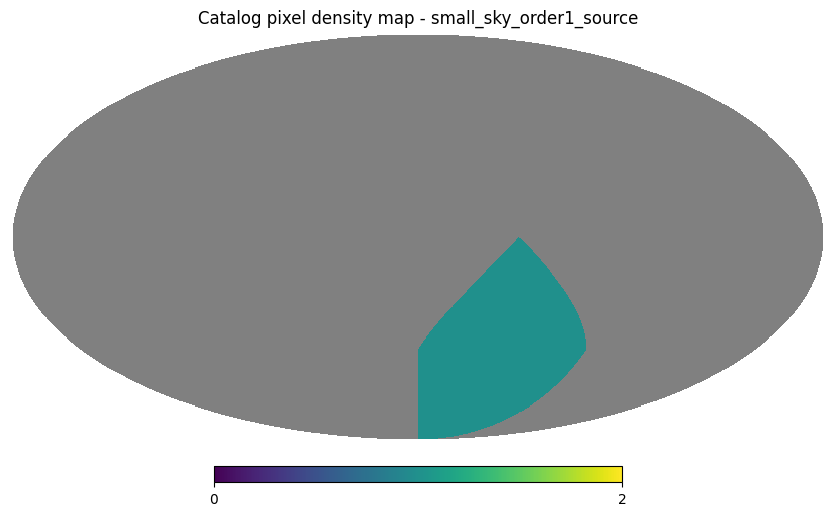

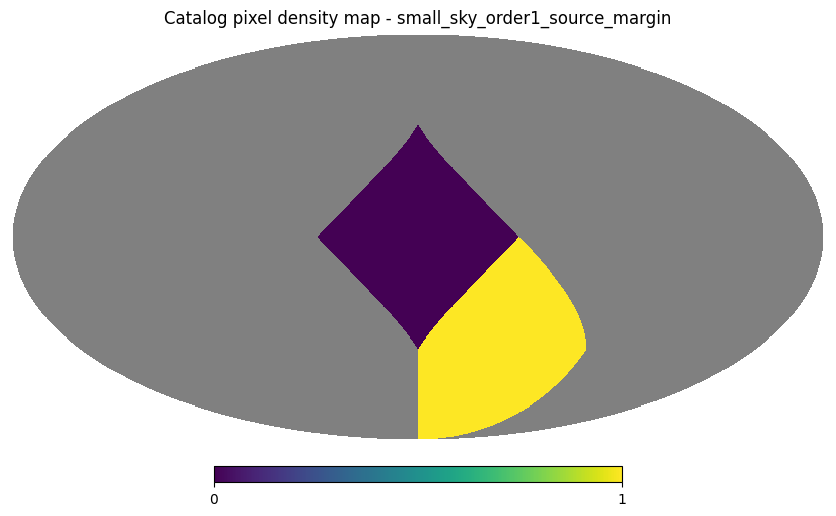

In [6]:
plot_pixels(sso1.hc_structure)
plot_pixels(sso1_source.hc_structure)
plot_pixels(sso1_source.margin.hc_structure)

This margin catalog is an example of negative margin pixels, where the margin includes pixels not in the original catalog where there are points close to a boundary with empty space. 

In [10]:
order = 1
pixel = 45

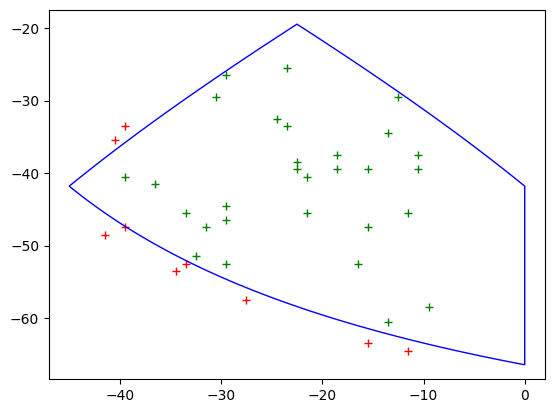

In [19]:
def plot_points(pixel_dfs, order, pixel, colors, ra_columns, dec_columns, xlim=None, ylim=None, alpha=1):
    ax = plt.subplot()

    # Plot hp pixel bounds
    nsides = hp.order2nside(order)
    pix0_bounds = hp.vec2dir(hp.boundaries(nsides, pixel, step=100, nest=True), lonlat=True)
    lon = pix0_bounds[0]
    lat = pix0_bounds[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')

    for pixel_df, color, ra_column, dec_column in zip(pixel_dfs, colors, ra_columns, dec_columns):
        ax.scatter(pixel_df[ra_column].values - 360, pixel_df[dec_column].values, c=color, marker='+', linewidths=1, alpha=alpha)
    ax.add_patch(p)

    VIEW_MARGIN = 2

    xlim_low = np.min(lon) - VIEW_MARGIN if xlim is None else xlim[0]
    xlim_high = np.max(lon) + VIEW_MARGIN if xlim is None else xlim[1]
    ylim_low = np.min(lat) - VIEW_MARGIN if ylim is None else ylim[0]
    ylim_high = np.max(lat) + VIEW_MARGIN if ylim is None else ylim[1]

    plt.xlim(xlim_low, xlim_high)
    plt.ylim(ylim_low, ylim_high)
    plt.show()

plot_points([sso1_source.get_partition(order, pixel).compute(), sso1_source.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'])

### Querying catalogs with margins

In [27]:
queried = sso1_source.query('ra < 340')
queried

,id,ra,dec,ra_error,dec_error,obj_id,Norder,Dir,Npix
npartitions=4,,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int64,int64,int64,int64
12970366926827028480,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...


Here we see that the margin is now included in the result of the queried catalog

In [28]:
queried.margin

,id,ra,dec,ra_error,dec_error,obj_id,margin_Norder,margin_Dir,margin_Npix,Norder,Npix,Dir
npartitions=5,,,,,,,,,,,,
4611686018427387904,int64,float64,float64,int64,int64,int64,int64,int64,int64,uint8,uint64,uint64
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...


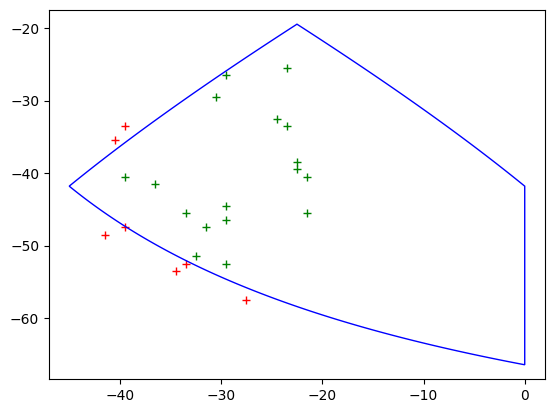

In [29]:
plot_points([queried.get_partition(order, pixel).compute(), queried.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'])

The query is performed correctly on the margin and the catalog

### Joining catalogs

In [15]:
joined = sso1.join(sso1_source, left_on='id', right_on='obj_id')
joined

,id_small_sky_order1,ra_small_sky_order1,dec_small_sky_order1,ra_error_small_sky_order1,dec_error_small_sky_order1,Norder_small_sky_order1,Dir_small_sky_order1,Npix_small_sky_order1,id_small_sky_order1_source,ra_small_sky_order1_source,dec_small_sky_order1_source,ra_error_small_sky_order1_source,dec_error_small_sky_order1_source,obj_id_small_sky_order1_source,Norder_small_sky_order1_source,Dir_small_sky_order1_source,Npix_small_sky_order1_source
npartitions=4,,,,,,,,,,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int32,int32,int32,int64,float64,float64,int64,int64,int64,int64,int64,int64
12970366926827028480,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


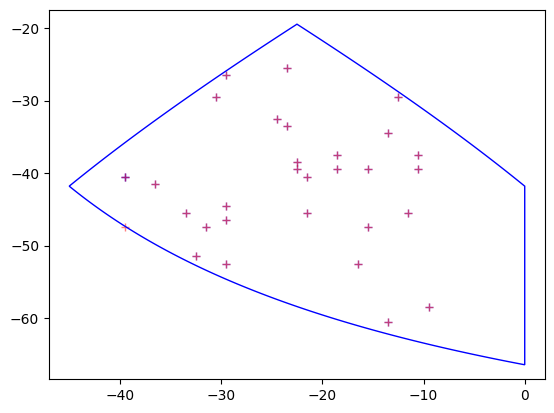

In [21]:
jc = joined.get_partition(order, pixel).compute()
plot_points([jc, jc], order, pixel, ['blue', 'red'], ['ra_small_sky_order1', 'ra_small_sky_order1_source'], ['dec_small_sky_order1', 'dec_small_sky_order1_source'], alpha=0.5)

Here we see the join for this partition used the margin, with the point at ~ -40, -47 being joined in the partition

We can also use margins in the join through an association table

In [22]:
association = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_to_o1source")
association

/astro/users/seanmcgu/hipscat_deploy/src/hipscat/catalog/partition_info.py:138: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")
/astro/users/seanmcgu/hipscat_deploy/src/hipscat/catalog/association_catalog/partition_join_info.py:165: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")


,index,id,Norder,Dir,Npix,join_Norder,join_Dir,join_Npix
npartitions=1,,,,,,,,
12682136550675316736,int64,int64,uint8,uint64,uint64,uint8,uint64,uint64
18446744073709551615,...,...,...,...,...,...,...,...


In [24]:
small_sky = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky")
small_sky

,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix
npartitions=1,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int32,int32,int32
18446744073709551615,...,...,...,...,...,...,...,...


In [41]:
joined_assoc = small_sky.join(sso1_source, through=association)
joined_assoc

,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_order1_source,ra_small_sky_order1_source,dec_small_sky_order1_source,ra_error_small_sky_order1_source,dec_error_small_sky_order1_source,obj_id_small_sky_order1_source,Norder_small_sky_order1_source,Dir_small_sky_order1_source,Npix_small_sky_order1_source
npartitions=4,,,,,,,,,,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int32,int32,int32,int64,float64,float64,int64,int64,int64,int64,int64,int64
12970366926827028480,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


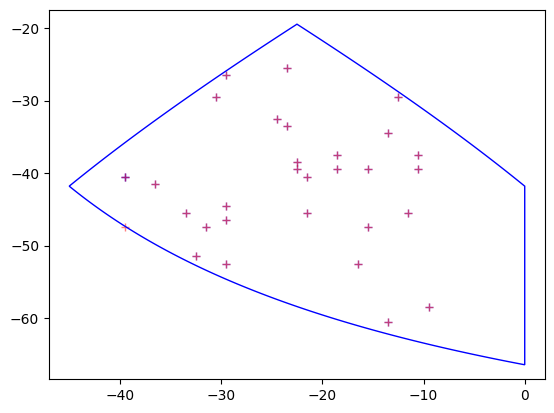

In [42]:
jadf = joined_assoc.get_partition(order, pixel).compute()
plot_points([jadf, jadf], order, pixel, ['blue', 'red'], ['ra_small_sky', 'ra_small_sky_order1_source'], ['dec_small_sky', 'dec_small_sky_order1_source'], alpha=0.5)

Here we see the same result

Putting it together, joining after performing a query also works

In [43]:
queried_joined = small_sky.join(queried, through=association)
queried_joined

,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_order1_source,ra_small_sky_order1_source,dec_small_sky_order1_source,ra_error_small_sky_order1_source,dec_error_small_sky_order1_source,obj_id_small_sky_order1_source,Norder_small_sky_order1_source,Dir_small_sky_order1_source,Npix_small_sky_order1_source
npartitions=4,,,,,,,,,,,,,,,,,
12682136550675316736,int64,float64,float64,int64,int64,int32,int32,int32,int64,float64,float64,int64,int64,int64,int64,int64,int64
12970366926827028480,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


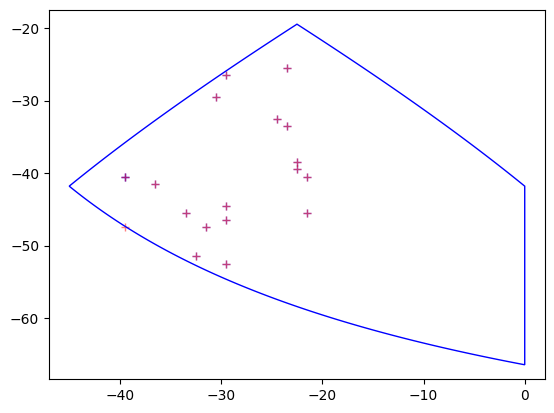

In [44]:
qjdf = queried_joined.get_partition(order, pixel).compute()
plot_points([qjdf, qjdf], order, pixel, ['blue', 'red'], ['ra_small_sky', 'ra_small_sky_order1_source'], ['dec_small_sky', 'dec_small_sky_order1_source'], alpha=0.5)

Here we see the result with the same margin pixel included, though this time only the points in the queried catalog are included